In [7]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


# Data Cleaning

In [175]:
import streamlit as st
import pandas as pd
import joblib
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [293]:
# Load the dataset
file_path = "./spam.csv"
df = pd.read_csv(file_path).copy()

# Display basic information and first few rows
df_info = df.info()
df_head = df.head()

df_info, df_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


(None,
   Category                                            Message
 0      ham  Go until jurong point, crazy.. Available only ...
 1      ham                      Ok lar... Joking wif u oni...
 2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
 3      ham  U dun say so early hor... U c already then say...
 4      ham  Nah I don't think he goes to usf, he lives aro...)

In [263]:
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [265]:
df.columns

Index(['Category', 'Message'], dtype='object')

In [267]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


## Checking for missing values

In [270]:
# Check for missing values
df.isna().sum()

Category    0
Message     0
dtype: int64

## Removing duplicate values

In [295]:
# Check for duplicate values
df.duplicated().sum()
df= df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5157 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5157 non-null   object
 1   Message   5157 non-null   object
dtypes: object(2)
memory usage: 120.9+ KB


## Column Formatting and Final Dataset

In [313]:
# Renaming and Formatting Columns
df.rename(columns={'Category': 'Label', 'Message': 'Text'}, inplace=True)

# Convert categorical labels to numerical (Ham = 0, Spam = 1)
df.loc[:, 'Spam'] = df['Label'].apply(lambda x: 1 if x == 'spam' else 0)
df.info()

# Save cleaned dataset to a new CSV file
df.to_csv("cleaned_spam_data.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5157 entries, 0 to 5156
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5157 non-null   object
 1   Text    5157 non-null   object
 2   Spam    5157 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 121.0+ KB


# Exploratory Data Analysis (EDA)

## Analysing Class Distribution

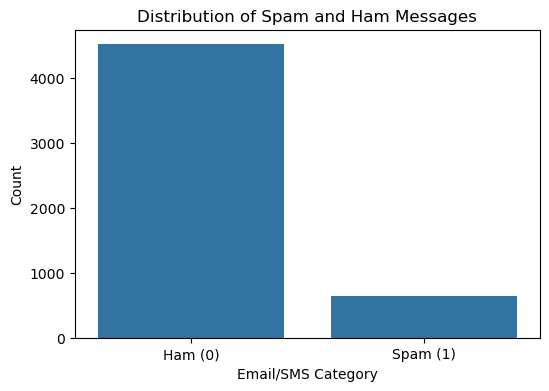

In [299]:
# Convert label to numerical (Ham = 0, Spam = 1)
df['Label'] = df['Label'].map({'ham': 0, 'spam': 1})

# Class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df['Label'])
plt.xticks(ticks=[0, 1], labels=["Ham (0)", "Spam (1)"])
plt.xlabel("Email/SMS Category")
plt.ylabel("Count")
plt.title("Distribution of Spam and Ham Messages")
plt.show()

## Wrod Frequency Analysis

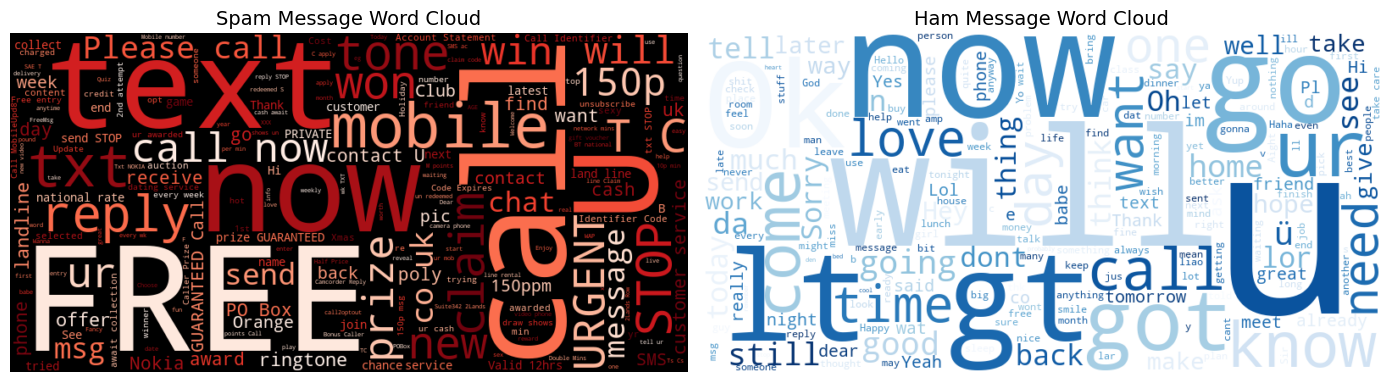

In [301]:
# Word cloud for Spam messages
spam_words = " ".join(df[df['Label'] == 1]['Text'])
spam_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(spam_words)

# Word cloud for Ham messages
ham_words = " ".join(df[df['Label'] == 0]['Text'])
ham_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(ham_words)

# Plot word clouds
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(spam_wordcloud, interpolation='bilinear')
axes[0].axis("off")
axes[0].set_title("Spam Message Word Cloud", fontsize=14)

axes[1].imshow(ham_wordcloud, interpolation='bilinear')
axes[1].axis("off")
axes[1].set_title("Ham Message Word Cloud", fontsize=14)

plt.tight_layout()
plt.show()

## Message Length Distribution

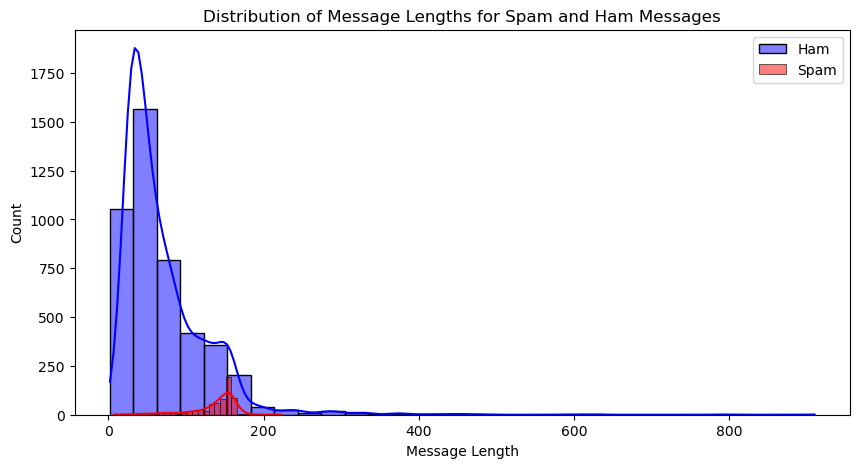

In [112]:
# Message length distribution
df['Text_Length'] = df['Text'].apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(df[df['Label'] == 0]['Text_Length'], bins=30, color='blue', label="Ham", kde=True)
sns.histplot(df[df['Label'] == 1]['Text_Length'], bins=30, color='red', label="Spam", kde=True)
plt.legend()
plt.xlabel("Message Length")
plt.ylabel("Count")
plt.title("Distribution of Message Lengths for Spam and Ham Messages")
plt.show()

# Data Preparation and Training

In [315]:
# Load dataset
# @st.cache_data
def load_data():
    file_path = "cleaned_spam_data.csv"
    df = pd.read_csv(file_path, encoding='latin-1')
    return df

# Load and preprocess data
df = load_data()
# Convert text into numerical format using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Text'])
y = df['Label']


# model generation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

## Model Analysis

In [318]:
# Train the model
model = MultinomialNB()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Model Accuracy: 0.97

Classification Report:
               precision    recall  f1-score   support

         ham       0.99      0.98      0.98       904
        spam       0.87      0.91      0.89       128

    accuracy                           0.97      1032
   macro avg       0.93      0.95      0.94      1032
weighted avg       0.97      0.97      0.97      1032



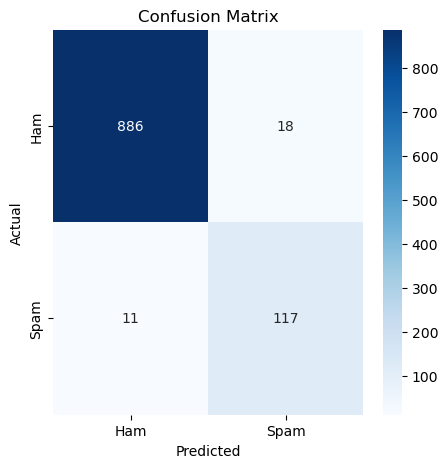

In [320]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()